# A predictive approach to estimate the maximum voluntary activation of the shoulder muscles

Romain Martinez<sup>*a</sup>, Jonathan Tremblay<sup>a</sup>, Mickael Begon<sup>a</sup>, Fabien Dal Maso<sup>a</sup>

<sup>a</sup>École de kinésiologie et des sciences de l’activité physique, Faculté de Medecine, Université de Montréal, Montréal, Canada

[GitHub repo](https://github.com/romainmartinez/mvc)

# Part 1: Getting the data

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import scipy.io as sio

# to make this notebook's output stable across runs
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [2]:
PROJECT_PATH = Path("./")
DATA_PATH = PROJECT_PATH / "data"
MODEL_PATH = PROJECT_PATH / "model"

## Read the data

We start this notebook with data in matlab format, where each file corresponds to different experiments.

Each file contains a 3-dimensional matrix where the first dimension corresponds to the _participant_, the second to the _tested muscle_ and the third to the _test performed_.

![Maximum voluntary isometric contraction tests performed.](./share/fig/positions.svg)

In [3]:
mat = {}
data = {key: [] for key in ("dataset", "participant", "muscle", "test", "mvc")}
dataset_names = []
count = -1


for ifile in DATA_PATH.glob("*only_max.mat"):
    # dataset name
    dataset = ifile.stem.replace("_only_max", "").replace("MVE_Data_", "")
    dataset_names.append(dataset)

    # data
    mat[dataset] = sio.loadmat(ifile)["MVE"]
    print(f"project {dataset}: {mat[dataset].shape[0]} participants")

    for iparticipant in range(mat[dataset].shape[0]):
        count += 1
        for imuscle in range(mat[dataset].shape[1]):
            for itest in range(mat[dataset].shape[2]):
                data["participant"].append(count)
                data["dataset"].append(dataset)
                data["muscle"].append(imuscle)
                data["test"].append(itest)
                data["mvc"].append(mat[dataset][iparticipant, imuscle, itest])

project Romain2017: 32 participants
project Landry2015_1: 14 participants
project Landry2016: 15 participants
project Violon: 10 participants
project Tennis: 16 participants
project Yoann_2015: 22 participants
project Landry2015_2: 11 participants
project Landry2012: 18 participants
project Patrick_2013: 16 participants
project Sylvain_2015: 10 participants
project Landry2013: 21 participants


## Transform the data

In [4]:
df_tidy = pd.DataFrame(data).dropna()
df_tidy["test"] = df_tidy["test"].apply(lambda x: f"test {str(x).zfill(2)}")

MUSCLES = [
    "upper trapezius",
    "middle trapezius",
    "lower trapezius",
    "anterior deltoid",
    "middle deltoid",
    "posterior deltoid",
    "pectoralis major",
    "serratus anterior",
    "latissimus dorsi",
    "supraspinatus",
    "infraspinatus",
    "subscapularis",
]


df_tidy["muscle"] = np.array(MUSCLES)[df_tidy["muscle"]]

print(f"dataset shape = {df_tidy.shape}")
df_tidy.head()


dataset shape = (18465, 5)


,dataset,participant,muscle,test,mvc
0,Romain2017,0,upper trapezius,test 00,0.000381
3,Romain2017,0,upper trapezius,test 03,0.000300
4,Romain2017,0,upper trapezius,test 04,0.000348
5,Romain2017,0,upper trapezius,test 05,0.000111
8,Romain2017,0,upper trapezius,test 08,0.000249


In [5]:
df_wide = df_tidy.pivot_table(
    index=["dataset", "participant", "muscle"],
    columns="test",
    values="mvc",
    fill_value=np.nan,
).reset_index()
df_wide.head()

test,dataset,participant,muscle,test 00,test 01,test 02,test 03,test 04,test 05,test 06,test 07,test 08,test 09,test 10,test 11,test 12,test 13,test 14,test 15
0,Landry2012,120,anterior deltoid,0.013480,0.060322,0.102243,0.262121,0.216671,0.007603,0.009864,0.030523,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Landry2012,120,latissimus dorsi,0.003968,0.077672,0.019619,0.024144,0.021569,0.151734,0.145337,0.060694,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Landry2012,120,lower trapezius,0.025092,0.205321,0.300761,0.170296,0.191271,0.070199,0.140505,0.017468,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Landry2012,120,middle deltoid,0.028731,0.145174,0.170468,0.085861,0.121181,0.035754,0.009872,0.011396,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Landry2012,120,middle trapezius,0.011083,0.135626,0.130890,0.042650,0.062615,0.046499,0.040964,0.016394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Part 2: Data exploration

In [6]:
import altair as alt
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

## Muscles and tests count

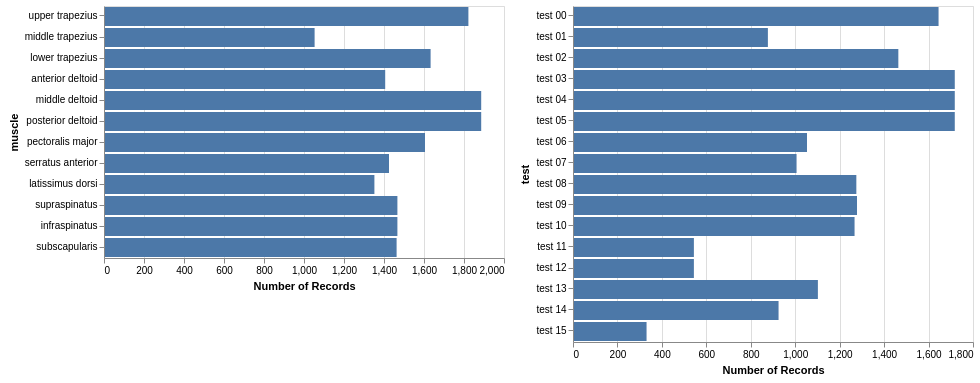

In [7]:
base = alt.Chart(df_tidy).encode(x="count()")
muscle = base.mark_bar().encode(alt.Y("muscle", sort=alt.Sort(MUSCLES)))
test = base.mark_bar().encode(y="test")
muscle | test

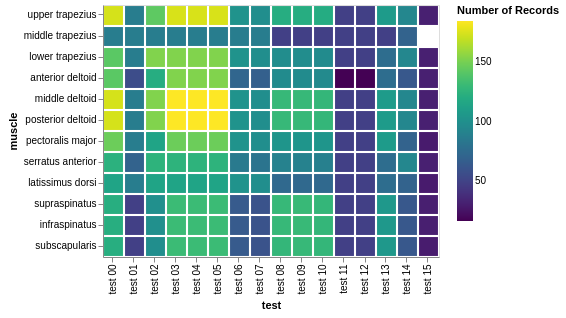

In [8]:
alt.Chart(df_tidy).mark_rect().encode(
    x="test", y=alt.Y("muscle", sort=alt.Sort(MUSCLES)), color="count()"
)

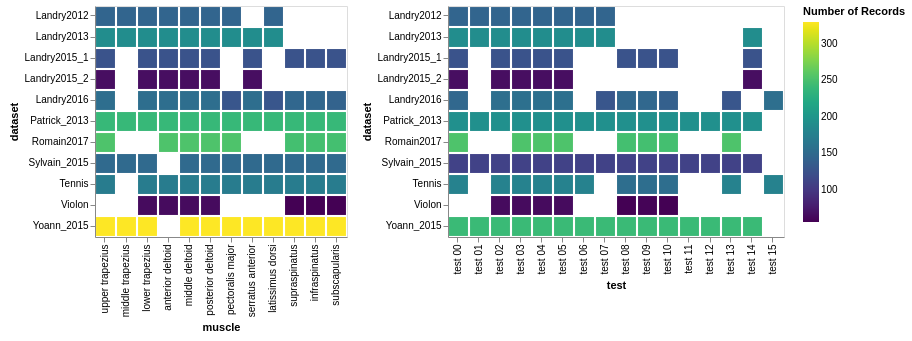

In [9]:
base = alt.Chart(df_tidy).encode(y="dataset", color="count()")
test = base.mark_rect().encode(x="test")
muscle = base.mark_rect().encode(alt.X("muscle", sort=alt.Sort(MUSCLES)))
muscle | test

## NaNs count

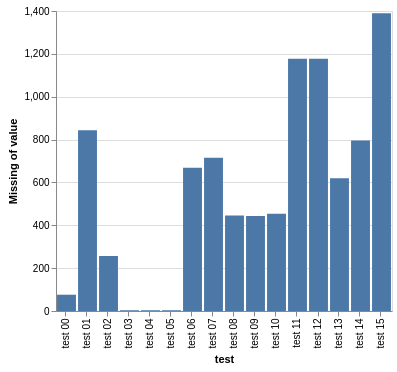

In [10]:
alt.Chart(df_wide.melt(id_vars=["dataset", "participant", "muscle"])).mark_bar().encode(
    x="test", y="missing(value)"
)

## Which test normalizes which muscle

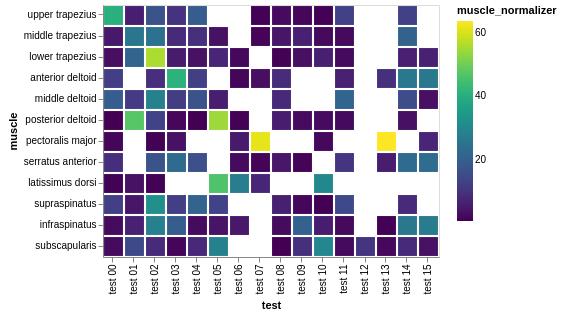

In [11]:
dff = df_tidy.groupby(["test", "muscle"])["mvc"].count().rename("count").to_frame()

max_test = (
    df_tidy.groupby(["participant", "muscle"], as_index=False)
    .apply(lambda x: x["test"][x["mvc"].idxmax()])
    .rename("test")
    .reset_index()
)

dff = dff.merge(
    max_test.groupby(["muscle", "test"]).count().reset_index(), on=["muscle", "test"]
).rename(columns={"participant": "max_test"})


dff["muscle_normalizer"] = dff["max_test"] / dff["count"] * 100

alt.Chart(dff).mark_rect().encode(
    x="test", y=alt.Y("muscle", sort=alt.Sort(MUSCLES)), color="muscle_normalizer"
)

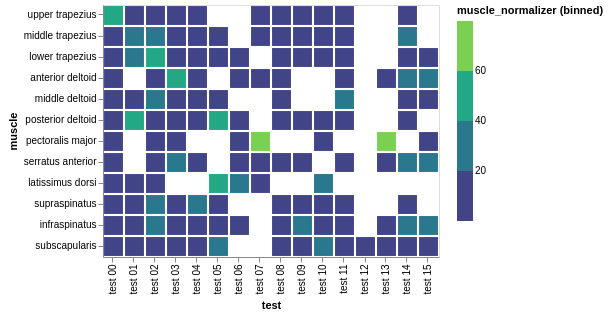

In [12]:
alt.Chart(dff).mark_rect().encode(
    x="test",
    y=alt.Y("muscle", sort=alt.Sort(MUSCLES)),
    color=alt.Color("muscle_normalizer", bin=True),
)


# Part 3: Machine learning pipeline

## Split the data

We want to make sure that all the data from one participant is in only one set

In [13]:
X = df_wide.drop("dataset", axis=1)
y = X.drop("participant", axis=1).max(axis=1)
X.head()


test,participant,muscle,test 00,test 01,test 02,test 03,test 04,test 05,test 06,test 07,test 08,test 09,test 10,test 11,test 12,test 13,test 14,test 15
0,120,anterior deltoid,0.013480,0.060322,0.102243,0.262121,0.216671,0.007603,0.009864,0.030523,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,120,latissimus dorsi,0.003968,0.077672,0.019619,0.024144,0.021569,0.151734,0.145337,0.060694,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,120,lower trapezius,0.025092,0.205321,0.300761,0.170296,0.191271,0.070199,0.140505,0.017468,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,120,middle deltoid,0.028731,0.145174,0.170468,0.085861,0.121181,0.035754,0.009872,0.011396,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,120,middle trapezius,0.011083,0.135626,0.130890,0.042650,0.062615,0.046499,0.040964,0.016394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
X.iloc[train_inds]

test,participant,muscle,test 00,test 01,test 02,test 03,test 04,test 05,test 06,test 07,test 08,test 09,test 10,test 11,test 12,test 13,test 14,test 15
0,120,anterior deltoid,0.013480,0.060322,0.102243,0.262121,0.216671,0.007603,0.009864,0.030523,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,120,latissimus dorsi,0.003968,0.077672,0.019619,0.024144,0.021569,0.151734,0.145337,0.060694,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,120,lower trapezius,0.025092,0.205321,0.300761,0.170296,0.191271,0.070199,0.140505,0.017468,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,120,middle deltoid,0.028731,0.145174,0.170468,0.085861,0.121181,0.035754,0.009872,0.011396,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,120,middle trapezius,0.011083,0.135626,0.130890,0.042650,0.062615,0.046499,0.040964,0.016394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,120,pectoralis major,0.001964,0.004088,0.004808,0.007162,0.007963,0.005317,0.059721,0.177546,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,120,posterior deltoid,0.013958,0.178541,0.157684,0.078236,0.087945,0.084121,0.030647,0.031408,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,120,upper trapezius,0.045527,0.065225,0.059689,0.081659,0.104184,0.024472,0.014294,0.012183,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,121,anterior deltoid,0.312934,0.041857,0.101595,0.332205,0.293422,0.072814,0.007218,0.127667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,121,latissimus dorsi,0.011169,0.085583,0.037194,0.013693,0.013132,0.169028,0.130943,0.029250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
from sklearn.model_selection import GroupShuffleSplit

TEST_SIZE = 0.2

train_inds, test_inds = next(
    GroupShuffleSplit(test_size=TEST_SIZE, random_state=RANDOM_SEED).split(
        X, groups=X["participant"]
    )
)
X_train, X_test, y_train, y_test = (
    X.iloc[train_inds],
    X.iloc[test_inds],
    y[train_inds],
    y[test_inds],
)

In [24]:
X_train['participant'].unique()

array([120, 121, 122, 123, 125, 127, 128, 129, 130, 131, 132, 133, 134,
       136, 137, 164, 166, 167, 168, 169, 171, 172, 173, 174, 177, 178,
       179, 180, 181, 182, 183, 184,  32,  33,  34,  36,  37,  38,  39,
        40,  41,  43,  44, 109, 110, 112, 114, 115, 116, 118,  46,  47,
        48,  49,  50,  52,  53,  54,  57,  58,  59, 138, 139, 140, 141,
       142, 143, 144, 145, 147, 149, 150, 151, 152, 153,   0,   1,   2,
         3,   4,   5,   6,   7,   8,  10,  11,  12,  13,  14,  17,  20,
        21,  22,  23,  25,  26,  27,  28,  31, 154, 155, 157, 158, 159,
       160, 161, 162,  71,  72,  73,  74,  76,  77,  78,  79,  80,  81,
        83,  84,  85,  86,  61,  62,  63,  64,  65,  67,  70,  87,  88,
        89,  90,  91,  92,  93,  94,  95,  96,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108])

In [25]:
X_test['participant'].unique()

array([124, 126, 135, 165, 170, 175, 176,  35,  42,  45, 111, 113, 117,
       119,  51,  55,  56,  60, 146, 148,   9,  15,  16,  18,  19,  24,
        29,  30, 156, 163,  75,  82,  66,  68,  69,  97,  98])

In [17]:
325 / 1396 * 100

23.280802292263612

In [15]:
train_inds.shape

(1396,)

In [16]:
test_inds.shape

(325,)

In [18]:
train_inds

array([   0,    1,    2, ..., 1718, 1719, 1720])

In [25]:
gkf = list(GroupKFold( n_splits=3).split(X,y,groups=X.participant))
len(gkf)

3

In [20]:
from sklearn.model_selection import GroupKFold

gkf = GroupKFold()
for train, test in gkf.split(X, y, groups=X.participant):
    train.shape

[   0    1    2 ... 1718 1719 1720] [  32   33   34   35   36   37   38   39   56   57   58   59   60   61
   62   63   64   65   66   67   68   69   70   71   88   89   90   91
   92   93   94   95   96   97   98   99  100  101  102  103  104  105
  106  107  108  109  110  111  128  129  130  131  132  133  134  135
  162  163  164  165  166  167  168  169  170  198  199  200  201  202
  203  204  205  206  225  226  227  228  229  230  231  232  233  252
  253  254  255  256  257  258  259  260  279  280  281  282  283  284
  285  286  287  306  307  308  309  310  311  312  313  314  324  325
  326  327  328  329  330  331  332  342  343  344  345  346  347  348
  349  350  369  370  371  372  373  374  375  376  377  405  406  407
  408  409  410  411  412  413  423  424  425  426  427  428  429  430
  431  471  472  473  474  475  476  495  496  497  498  499  500  501
  502  503  504  505  506  519  520  521  522  523  524  525  526  527
  528  529  530  531  532  533  534  535 

/home/romain/miniconda3/envs/mvc/lib/python3.6/site-packages/sklearn/model_selection/_split.py:497: FutureWarning: You should specify a value for 'n_splits' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(NSPLIT_WARNING, FutureWarning)


In [17]:
from sklearn.model_selection import train_test_split

train_test_split()